<a href="https://colab.research.google.com/github/ReshmiVP/CI-CD-for-machine-learning-/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d3d74aa77b670adc096e96ec57eedec5bf24f01da9879aa5fe959893a0ce42b1
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, ltrim
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, count, isnan, isnull, when
import pyspark.sql.functions as f

In [ ]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Smoking Drinking") \
    .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

data_path = "/content/drive/MyDrive/smoking_driking_dataset_Ver01.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [ ]:
df.printSchema()

root
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: integer (nullable = true)
 |-- waistline: double (nullable = true)
 |-- sight_left: double (nullable = true)
 |-- sight_right: double (nullable = true)
 |-- hear_left: double (nullable = true)
 |-- hear_right: double (nullable = true)
 |-- SBP: double (nullable = true)
 |-- DBP: double (nullable = true)
 |-- BLDS: double (nullable = true)
 |-- tot_chole: double (nullable = true)
 |-- HDL_chole: double (nullable = true)
 |-- LDL_chole: double (nullable = true)
 |-- triglyceride: double (nullable = true)
 |-- hemoglobin: double (nullable = true)
 |-- urine_protein: double (nullable = true)
 |-- serum_creatinine: double (nullable = true)
 |-- SGOT_AST: double (nullable = true)
 |-- SGOT_ALT: double (nullable = true)
 |-- gamma_GTP: double (nullable = true)
 |-- SMK_stat_type_cd: double (nullable = true)
 |-- DRK_YN: string (nullable = true)



In [ ]:
df.show()

+------+---+------+------+---------+----------+-----------+---------+----------+-----+-----+-----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+
|   sex|age|height|weight|waistline|sight_left|sight_right|hear_left|hear_right|  SBP|  DBP| BLDS|tot_chole|HDL_chole|LDL_chole|triglyceride|hemoglobin|urine_protein|serum_creatinine|SGOT_AST|SGOT_ALT|gamma_GTP|SMK_stat_type_cd|DRK_YN|
+------+---+------+------+---------+----------+-----------+---------+----------+-----+-----+-----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+
|  Male| 35|   170|    75|     90.0|       1.0|        1.0|      1.0|       1.0|120.0| 80.0| 99.0|    193.0|     48.0|    126.0|        92.0|      17.1|          1.0|             1.0|    21.0|    35.0|     40.0|             1.0|     Y|
|  Male| 30|   180|    80|     89.0|       0.9|        1

# **Data Preprocessing**

In [ ]:
num_rows = df.count()
num_columns = len(df.columns)

print(f"Shape of the DataFrame: ({num_rows}, {num_columns})")

Shape of the DataFrame: (991346, 24)


In [ ]:
df.describe().show()

+-------+------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------+
|summary|   sex|               age|            height|            weight|         waistline|        sight_left|       sight_right|        hear_left|         hear_right|               SBP|              DBP|              BLDS|         tot_chole|         HDL_chole|         LDL_chole|      triglyceride|        hemoglobin|     urine_protein|  serum_creatinine|          SGOT_AST|          SGOT_ALT|         gamma_GTP|  SMK_stat_type_cd|DRK_YN|
+-------+------+------------------+------------------+------------------+------------------+------------------+-------

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum
spark = SparkSession.builder \
    .appName("Count Missing Values") \
    .getOrCreate()
df = spark.read.csv("/content/drive/MyDrive/smoking_driking_dataset_Ver01.csv", header=True, inferSchema=True)

missing_counts = [spark_sum(col(column).isNull().cast("int")).alias(column) for column in df.columns]

missing_counts_summary = df.agg(*missing_counts)
missing_counts_summary.show()
spark.stop()

+---+---+------+------+---------+----------+-----------+---------+----------+---+---+----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+
|sex|age|height|weight|waistline|sight_left|sight_right|hear_left|hear_right|SBP|DBP|BLDS|tot_chole|HDL_chole|LDL_chole|triglyceride|hemoglobin|urine_protein|serum_creatinine|SGOT_AST|SGOT_ALT|gamma_GTP|SMK_stat_type_cd|DRK_YN|
+---+---+------+------+---------+----------+-----------+---------+----------+---+---+----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+
|  0|  0|     0|     0|        0|         0|          0|        0|         0|  0|  0|   0|        0|        0|        0|           0|         0|            0|               0|       0|       0|        0|               0|     0|
+---+---+------+------+---------+----------+-----------+---------+----------+---+---+---

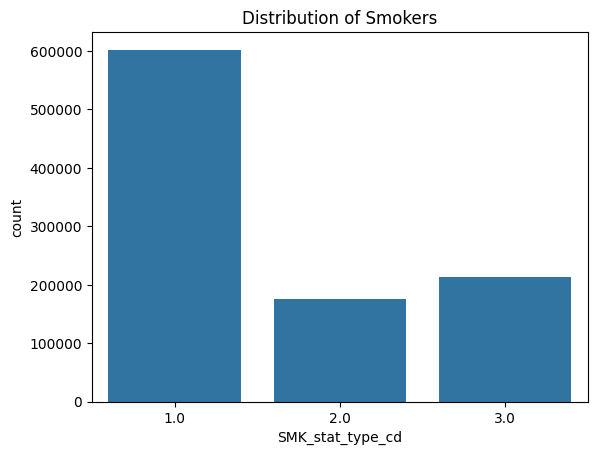

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
smokedrink = pd.read_csv("/content/drive/MyDrive/smoking_driking_dataset_Ver01.csv")
sns.countplot(x='SMK_stat_type_cd', data=smokedrink)
plt.title('Distribution of Smokers')
plt.show()
print()

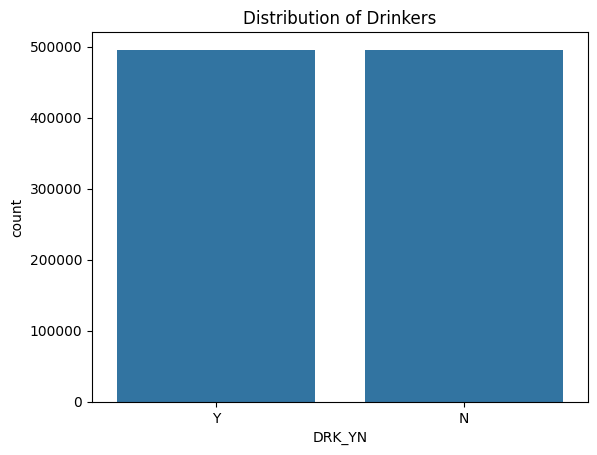

In [ ]:
smokedrink = pd.read_csv("/content/drive/MyDrive/smoking_driking_dataset_Ver01.csv")
sns.countplot(x='DRK_YN', data=smokedrink)
plt.title('Distribution of Drinkers')
plt.show()
print()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("count") \
    .getOrCreate()

df.groupBy('SMK_stat_type_cd').count().show()
df.groupby('DRK_YN').count().show()
spark.stop()


+----------------+------+
|SMK_stat_type_cd| count|
+----------------+------+
|             1.0|602441|
|             3.0|213954|
|             2.0|174951|
+----------------+------+

+------+------+
|DRK_YN| count|
+------+------+
|     Y|495488|
|     N|495858|
+------+------+



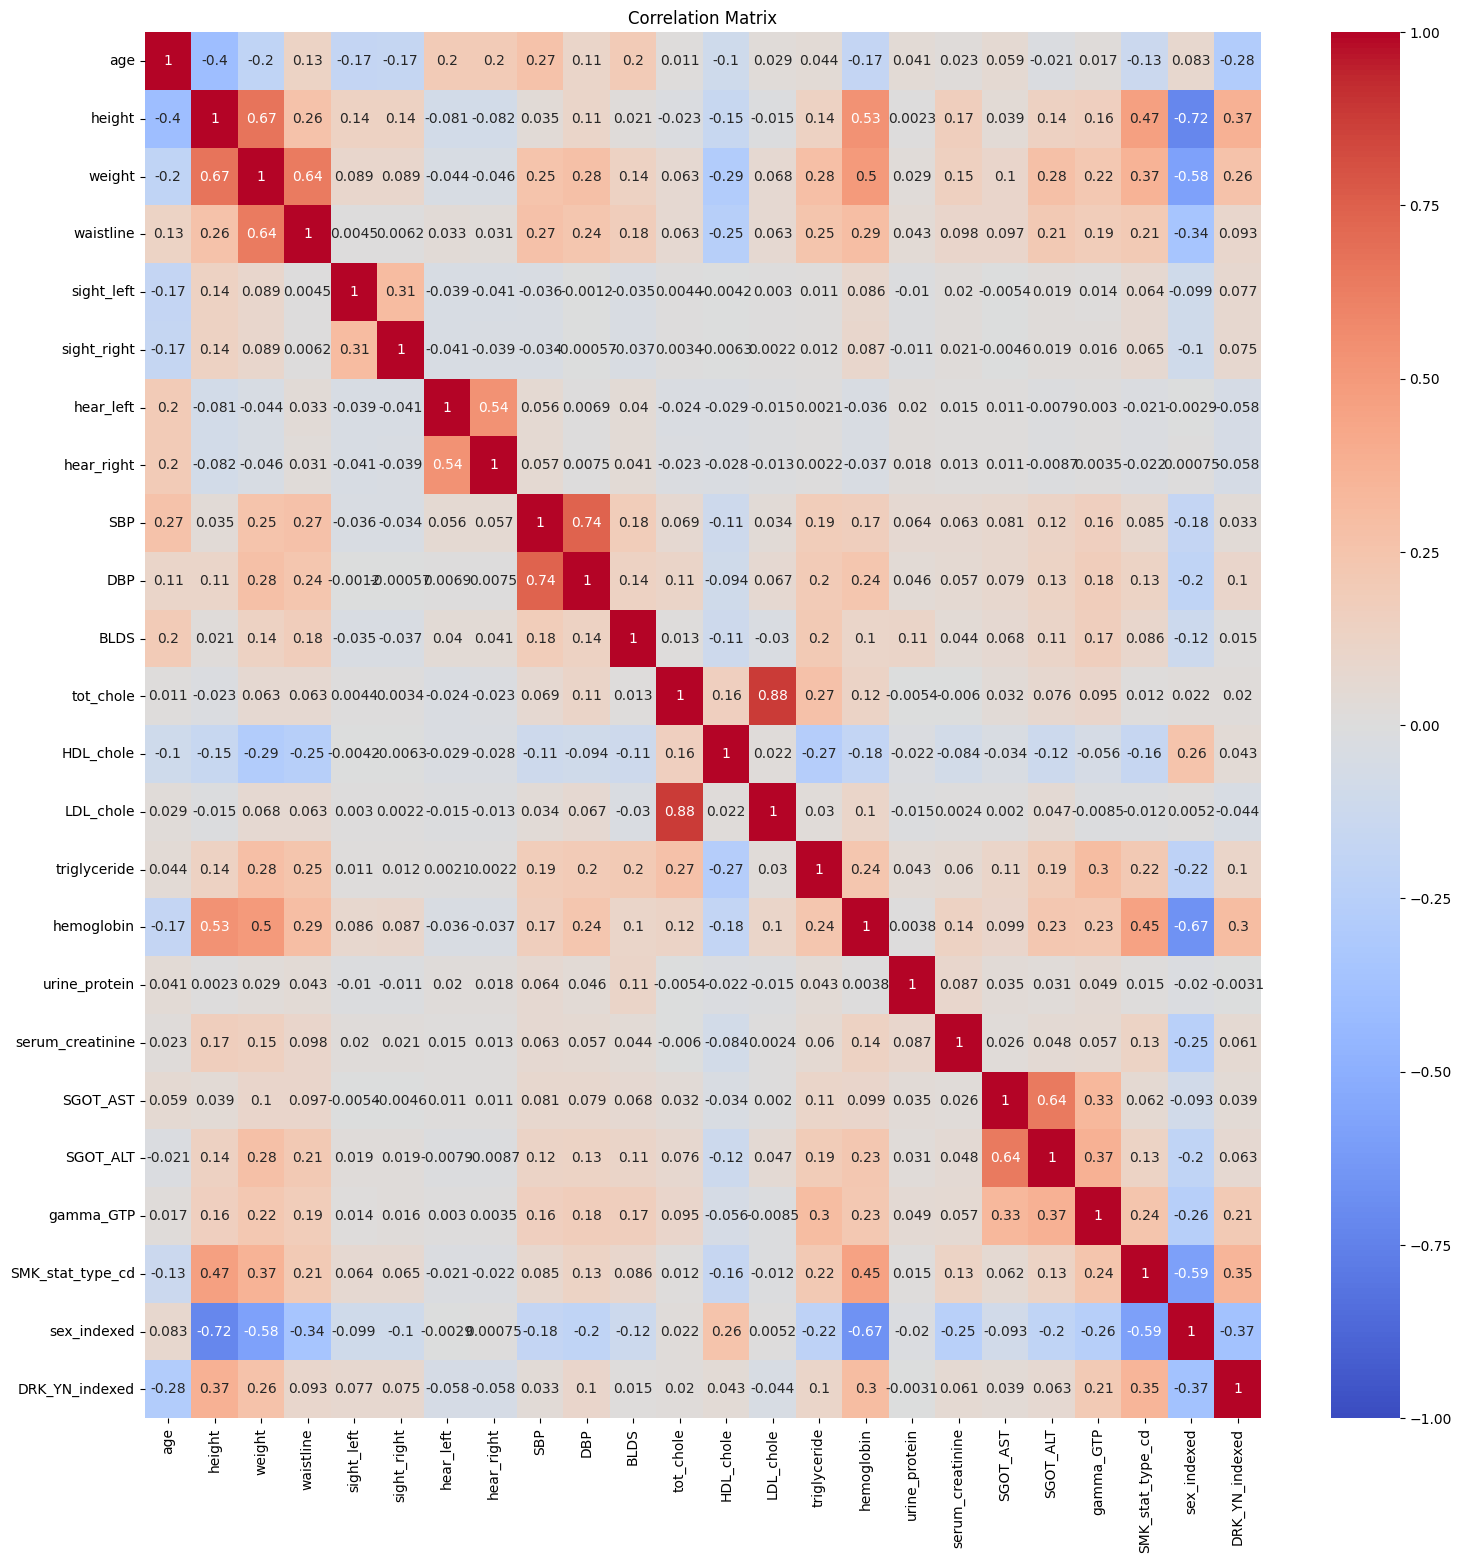

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col


spark = SparkSession.builder \
    .appName("Correlation Matrix") \
    .getOrCreate()


df = spark.read.csv("/content/drive/MyDrive/smoking_driking_dataset_Ver01.csv", header=True, inferSchema=True)

# Convert categorical variables into numerical values
indexer_sex = StringIndexer(inputCol="sex", outputCol="sex_indexed")
indexer_drk = StringIndexer(inputCol="DRK_YN", outputCol="DRK_YN_indexed")

df = indexer_sex.fit(df).transform(df)
df = indexer_drk.fit(df).transform(df)

# Drop original categorical columns
df = df.drop("sex").drop("DRK_YN")

# List of feature columns for correlation matrix
feature_cols = df.columns

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_vector = assembler.transform(df).select("features")

# Compute the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()[0]

# Convert the correlation matrix to a pandas DataFrame
correlation_array = correlation_matrix.toArray()
correlation_df = pd.DataFrame(correlation_array, index=feature_cols, columns=feature_cols)

# Plot the correlation matrix
plt.figure(figsize=(18, 18))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

# Stop Spark session
spark.stop()


In [ ]:

columns_to_drop = ["hear_left", "hear_right", "SBP","LDL_chole"]
df = df.drop(*columns_to_drop)
df.printSchema()




root
 |-- age: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: integer (nullable = true)
 |-- waistline: double (nullable = true)
 |-- sight_left: double (nullable = true)
 |-- sight_right: double (nullable = true)
 |-- DBP: double (nullable = true)
 |-- BLDS: double (nullable = true)
 |-- tot_chole: double (nullable = true)
 |-- HDL_chole: double (nullable = true)
 |-- triglyceride: double (nullable = true)
 |-- hemoglobin: double (nullable = true)
 |-- urine_protein: double (nullable = true)
 |-- serum_creatinine: double (nullable = true)
 |-- SGOT_AST: double (nullable = true)
 |-- SGOT_ALT: double (nullable = true)
 |-- gamma_GTP: double (nullable = true)
 |-- SMK_stat_type_cd: double (nullable = true)
 |-- sex_indexed: double (nullable = false)
 |-- DRK_YN_indexed: double (nullable = false)



# sql queries

In [ ]:

data_path = "/content/drive/MyDrive/smoking_driking_dataset_Ver01.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)
df.createOrReplaceTempView("smokedrink_data")

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("sql query") \
    .getOrCreate()

df.createOrReplaceTempView("smokedrink_data")
a1 = spark.sql("SELECT COUNT(*) AS Total_Records FROM smokedrink_data")
a1.show()
spark.stop()


+-------------+
|Total_Records|
+-------------+
|       991346|
+-------------+



In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SmokedrinkAnalysis") \
    .getOrCreate()

result_drink = spark.sql("""
    SELECT sex, DRK_YN, COUNT(*) AS count
    FROM smokedrink_data
    GROUP BY sex, DRK_YN
    ORDER BY sex, DRK_YN
""")
result_drink.show()
spark.stop()


+------+------+------+
|   sex|DRK_YN| count|
+------+------+------+
|Female|     N|323760|
|Female|     Y|141171|
|  Male|     N|172098|
|  Male|     Y|354317|
+------+------+------+



In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SmokedrinkAnalysis") \
    .getOrCreate()

result_smoke = spark.sql("""
    SELECT sex, SMK_stat_type_cd, COUNT(*) AS count
    FROM smokedrink_data
    GROUP BY sex, SMK_stat_type_cd
    ORDER BY sex, SMK_stat_type_cd
""")
result_smoke.show()
spark.stop()


+------+----------------+------+
|   sex|SMK_stat_type_cd| count|
+------+----------------+------+
|Female|             1.0|437760|
|Female|             2.0| 10923|
|Female|             3.0| 16248|
|  Male|             1.0|164681|
|  Male|             2.0|164028|
|  Male|             3.0|197706|
+------+----------------+------+



In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SmokedrinkAnalysis") \
    .getOrCreate()

result_avg_age = spark.sql("""
    SELECT sex, AVG(age) AS avg_age
    FROM smokedrink_data
    GROUP BY sex
""")
result_avg_age.show()
spark.stop()


+------+----------------+
|   sex|         avg_age|
+------+----------------+
|Female|48.8703485033263|
|  Male|46.5053142482642|
+------+----------------+



In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("SmokedrinkAnalysis") \
    .getOrCreate()
result_bp_waist_weight = spark.sql("""
    SELECT AVG(waistline) AS avg_waistline,
           AVG(weight) AS avg_weight
    FROM smokedrink_data
    WHERE SBP > 140 OR DBP > 90
""")
result_bp_waist_weight.show()
spark.stop()

+-----------------+-----------------+
|    avg_waistline|       avg_weight|
+-----------------+-----------------+
|86.04711329793155|67.03624253697758|
+-----------------+-----------------+



In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("SmokedrinkAnalysis") \
    .getOrCreate()
result_high_cholesterol = spark.sql("""
    SELECT sex, COUNT(*) AS count_high_cholesterol
    FROM smokedrink_data
    WHERE tot_chole > 200
    GROUP BY sex
""")
result_high_cholesterol.show()
spark.stop()

+------+----------------------+
|   sex|count_high_cholesterol|
+------+----------------------+
|Female|                197992|
|  Male|                221107|
+------+----------------------+



In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("sql query") \
    .getOrCreate()
df.createOrReplaceTempView("smokedrink_data")

# Execute SQL query to calculate average total cholesterol level of smoking people
average_cholesterol_smoking = spark.sql("""
    SELECT AVG(tot_chole) AS Average_Total_Cholesterol
    FROM smokedrink_data
    WHERE SMK_stat_type_cd = 1
""")

average_cholesterol_smoking.show()
spark.stop()


+-------------------------+
|Average_Total_Cholesterol|
+-------------------------+
|       195.33690602067256|
+-------------------------+



# ML CLASSIFIERS

# **1.Logistic Regression**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

spark = SparkSession.builder \
    .appName("ML Classifier") \
    .getOrCreate()
df = spark.read.csv("/content/drive/MyDrive/smoking_driking_dataset_Ver01.csv", header=True, inferSchema=True)

columns_to_drop = ["hear_left", "hear_right", "SBP","LDL_chole"]
df = df.drop(*columns_to_drop)

df.createOrReplaceTempView("smokedrink_data")

sql_query = """
    SELECT
        *,
        CASE WHEN sex = 'Male' THEN 1 ELSE 2 END AS sex_mapped,
        CASE WHEN DRK_YN = 'Y' THEN 1 ELSE 0 END AS DRK_YN_mapped
    FROM smokedrink_data
"""

df_mapped = spark.sql(sql_query)
df_mapped = df_mapped.drop("sex").drop("DRK_YN")

df_mapped = df_mapped.withColumnRenamed("sex_mapped", "sex").withColumnRenamed("DRK_YN_mapped", "DRK_YN")
feature_cols = [col for col in df_mapped.columns if col not in ["DRK_YN", "SMK_stat_type_cd"]]

def train_and_evaluate(target_col):
    print(f"\nTraining model for target column: {target_col}")

    # Prepare the data for the target column
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df_target = df_mapped.withColumnRenamed(target_col, "label")


    train_data, test_data = df_target.randomSplit([0.8, 0.2], seed=42)


    lr = LogisticRegression(featuresCol='features', labelCol='label')

    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)
    predictions = model.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

    print(f" accuracy for {target_col} = {accuracy}")
    print(f" precision for {target_col} = {precision}")
    print(f" recall for {target_col} = {recall}")
    print(f" F1-score for {target_col} = {f1}")
    predictions.select("features", "label", "prediction").show(5)
train_and_evaluate("DRK_YN")
train_and_evaluate("SMK_stat_type_cd")
spark.stop()



Training model for target column: DRK_YN
 accuracy for DRK_YN = 0.7223065097406689
 precision for DRK_YN = 0.7223055786846402
 recall for DRK_YN = 0.7223065097406689
 F1-score for DRK_YN = 0.7223058643527377
+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[20.0,140.0,45.0,...|    1|       0.0|
|[20.0,145.0,35.0,...|    1|       0.0|
|[20.0,145.0,40.0,...|    1|       0.0|
|[20.0,145.0,40.0,...|    0|       0.0|
|[20.0,145.0,40.0,...|    1|       0.0|
+--------------------+-----+----------+
only showing top 5 rows


Training model for target column: SMK_stat_type_cd
 accuracy for SMK_stat_type_cd = 0.6782277779177903
 precision for SMK_stat_type_cd = 0.68666891367224
 recall for SMK_stat_type_cd = 0.6782277779177903
 F1-score for SMK_stat_type_cd = 0.679177133537795
+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[20.0,140.0,45.0,...|  1.0|  

# **2. Decision Tree**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

spark = SparkSession.builder \
    .appName("Decision Tree Classifier") \
    .getOrCreate()
df = spark.read.csv("/content/drive/MyDrive/smoking_driking_dataset_Ver01.csv", header=True, inferSchema=True)
columns_to_drop = ["hear_left", "hear_right", "SBP","LDL_chole"]
df = df.drop(*columns_to_drop)
df.createOrReplaceTempView("smoking_drinking_data")
sql_query = """
    SELECT
        *,
        CASE WHEN sex = 'Male' THEN 1 ELSE 2 END AS sex_mapped,
        CASE WHEN DRK_YN = 'Y' THEN 1 ELSE 0 END AS DRK_YN_mapped
    FROM smoking_drinking_data
"""
df_mapped = spark.sql(sql_query)
df_mapped = df_mapped.drop("sex").drop("DRK_YN")
df_mapped = df_mapped.withColumnRenamed("sex_mapped", "sex").withColumnRenamed("DRK_YN_mapped", "DRK_YN")

feature_cols = [col for col in df_mapped.columns if col not in ["DRK_YN", "SMK_stat_type_cd"]]
def train_and_evaluate(target_col):
    print(f"\nTraining model for target column: {target_col}")


    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df_target = df_mapped.withColumnRenamed(target_col, "label")

    train_data, test_data = df_target.randomSplit([0.8, 0.2], seed=42)

    dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')
    pipeline = Pipeline(stages=[assembler, dt])
    model = pipeline.fit(train_data)
    predictions = model.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

    print(f" accuracy for {target_col} = {accuracy}")
    print(f" precision for {target_col} = {precision}")
    print(f" recall for {target_col} = {recall}")
    print(f" F1-score for {target_col} = {f1}")
    predictions.select("features", "label", "prediction").show(5)

train_and_evaluate("DRK_YN")
train_and_evaluate("SMK_stat_type_cd")
spark.stop()



Training model for target column: DRK_YN
 accuracy for DRK_YN = 0.7139847274376875
 precision for DRK_YN = 0.7166172840109362
 recall for DRK_YN = 0.7139847274376875
 F1-score for DRK_YN = 0.7132182963672349
+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[20.0,140.0,45.0,...|    1|       1.0|
|[20.0,145.0,35.0,...|    1|       1.0|
|[20.0,145.0,40.0,...|    1|       0.0|
|[20.0,145.0,40.0,...|    0|       0.0|
|[20.0,145.0,40.0,...|    1|       0.0|
+--------------------+-----+----------+
only showing top 5 rows


Training model for target column: SMK_stat_type_cd
 accuracy for SMK_stat_type_cd = 0.682965800549409
 precision for SMK_stat_type_cd = 0.713275547126168
 recall for SMK_stat_type_cd = 0.682965800549409
 F1-score for SMK_stat_type_cd = 0.6949704498734375
+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[20.0,140.0,45.0,...|  1.0|  

# 3. Random Forest

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline


spark = SparkSession.builder \
    .appName("ML Classifier") \
    .getOrCreate()
df = spark.read.csv("/content/drive/MyDrive/smoking_driking_dataset_Ver01.csv", header=True, inferSchema=True)
columns_to_drop = ["hear_left", "hear_right", "SBP","LDL_chole"]
df = df.drop(*columns_to_drop)
df.createOrReplaceTempView("smoking_drinking_data")
sql_query = """
    SELECT
        *,
        CASE WHEN sex = 'Male' THEN 1 ELSE 2 END AS sex_mapped,
        CASE WHEN DRK_YN = 'Y' THEN 1 ELSE 0 END AS DRK_YN_mapped
    FROM smoking_drinking_data
"""
df_mapped = spark.sql(sql_query)
df_mapped = df_mapped.drop("sex").drop("DRK_YN")
df_mapped = df_mapped.withColumnRenamed("sex_mapped", "sex").withColumnRenamed("DRK_YN_mapped", "DRK_YN")
feature_cols = [col for col in df_mapped.columns if col not in ["DRK_YN", "SMK_stat_type_cd"]]

def train_and_evaluate(target_col):
    print(f"\nTraining model for target column: {target_col}")

    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df_target = df_mapped.withColumnRenamed(target_col, "label")
    train_data, test_data = df_target.randomSplit([0.8, 0.2], seed=42)
    rf = RandomForestClassifier(featuresCol='features', labelCol='label')
    pipeline = Pipeline(stages=[assembler, rf])
    model = pipeline.fit(train_data)
    predictions = model.transform(test_data)

    evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

    print(f" accuracy for {target_col} = {accuracy}")
    print(f" precision for {target_col} = {precision}")
    print(f" recall for {target_col} = {recall}")
    print(f" F1-score for {target_col} = {f1}")
    predictions.select("features", "label", "prediction").show(5)

train_and_evaluate("DRK_YN")
train_and_evaluate("SMK_stat_type_cd")
spark.stop()



Training model for target column: DRK_YN
 accuracy for DRK_YN = 0.7030973562841806
 precision for DRK_YN = 0.7031617930162462
 recall for DRK_YN = 0.7030973562841806
 F1-score for DRK_YN = 0.7030515170673147
+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[20.0,140.0,45.0,...|    1|       0.0|
|[20.0,145.0,35.0,...|    1|       0.0|
|[20.0,145.0,40.0,...|    1|       0.0|
|[20.0,145.0,40.0,...|    0|       0.0|
|[20.0,145.0,40.0,...|    1|       0.0|
+--------------------+-----+----------+
only showing top 5 rows


Training model for target column: SMK_stat_type_cd
 accuracy for SMK_stat_type_cd = 0.6814133420701126
 precision for SMK_stat_type_cd = 0.6581074886549093
 recall for SMK_stat_type_cd = 0.6814133420701127
 F1-score for SMK_stat_type_cd = 0.6622963941683252
+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[20.0,140.0,45.0,...|  1.0